In [4]:
%autosave 0

Autosave disabled


In [5]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import re
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns

## Cleaning the r/wallstreetsbets post data

In [100]:
posts = pd.read_csv("r_wallstreetbets_posts.csv")
# Look at some metrics on the data set
posts.head()
posts.describe()
len(posts)

/tmp/ipykernel_115128/3133331585.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv("r_wallstreetbets_posts.csv")


,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll0n5k,Whats going on with PLTR?,1,Zaccko98,NaN,moderator,0.0,[],1613469192,https://www.reddit.com/r/wallstreetbets/commen...,2,False
1,ll0n4p,"Need explanations on Level 2 data for GME, why...",1,toutoucnc,210115:1:1,moderator,0.0,[],1613469189,https://www.reddit.com/r/wallstreetbets/commen...,2,False
2,ll0my2,XRT is being used as a laundry short machine,1,thabat,NaN,moderator,0.0,[],1613469166,https://www.reddit.com/r/wallstreetbets/commen...,2,False
3,ll0mxr,Airlines?,1,AsianTwink_,NaN,moderator,0.0,[],1613469165,https://www.reddit.com/r/wallstreetbets/commen...,2,False
4,ll0mx4,Buy TRXC 🚀,1,Oneverystreet8,NaN,moderator,0.0,[],1613469164,https://www.reddit.com/r/wallstreetbets/commen...,2,False


,score,total_awards_received,created_utc,num_comments
count,1.118863e+06,917443.000000,1.118863e+06,1.118863e+06
mean,2.708020e+01,0.073045,1.586496e+09,3.005231e+01
std,7.467229e+02,3.516812,4.105946e+07,8.817346e+02
min,0.000000e+00,0.000000,1.334162e+09,0.000000e+00
25%,1.000000e+00,0.000000,1.582207e+09,0.000000e+00
50%,1.000000e+00,0.000000,1.611074e+09,0.000000e+00
75%,1.000000e+00,0.000000,1.611978e+09,4.000000e+00
max,1.348400e+05,571.000000,1.613469e+09,2.045510e+05


1118863

In [101]:
# Look at just the columns we are interested in
posts = posts[["title", "num_comments", "score", "created_utc"]]

In [102]:
posts.head()

,title,num_comments,score,created_utc
0,Whats going on with PLTR?,2,1,1613469192
1,"Need explanations on Level 2 data for GME, why...",2,1,1613469189
2,XRT is being used as a laundry short machine,2,1,1613469166
3,Airlines?,2,1,1613469165
4,Buy TRXC 🚀,2,1,1613469164


### Removing all emojis from titles (needed for sentiment analysis later)

In [93]:
# Import the regex (regular expression) python package
# Note: regex is used to for pattern matching strings
import re

# This function removes emojis from titles as we were unsure how they would affect sentiment anaysis
def remove_emojis(text):
  return re.sub(r'[^\w\s]', '', text)

# We converted each title to lowercase so we could determine if a title mentions a stock's ticker or
# company name without needing to worry about missing one due to not matching the exact casing used
posts.title = posts.title.apply(func=lambda x: remove_emojis(str(x)).lower())

In [103]:
posts

,title,num_comments,score,created_utc
0,Whats going on with PLTR?,2,1,1613469192
1,"Need explanations on Level 2 data for GME, why...",2,1,1613469189
2,XRT is being used as a laundry short machine,2,1,1613469166
3,Airlines?,2,1,1613469165
4,Buy TRXC 🚀,2,1,1613469164
...,...,...,...,...
1118858,"EBAY posts higher 1Q net income and revenue, s...",4,7,1334844620
1118859,Anyone betting on VVUS and their potential app...,0,1,1334670090
1118860,My poorly timed opening position for AAPL earn...,21,12,1334615377
1118861,"GOOG - beat estimates, price barely rises.",0,2,1334263051


## Setting up boolen columns for each stock which will be true if a post's title mentions the stock

In [104]:
# Initializing each stock's column to false
posts["tsla"] = False
posts["aapl"] = False
posts["amd"] = False
posts["msft"] = False
posts["amzn"] = False
posts = posts.set_index("title")
posts

,num_comments,score,created_utc,tsla,aapl,amd,msft,amzn
title,,,,,,,,
Whats going on with PLTR?,2,1,1613469192,False,False,False,False,False
"Need explanations on Level 2 data for GME, why isn’t the price higher if asks are only 4000$+",2,1,1613469189,False,False,False,False,False
XRT is being used as a laundry short machine,2,1,1613469166,False,False,False,False,False
Airlines?,2,1,1613469165,False,False,False,False,False
Buy TRXC 🚀,2,1,1613469164,False,False,False,False,False
...,...,...,...,...,...,...,...,...
"EBAY posts higher 1Q net income and revenue, soars.",4,7,1334844620,False,False,False,False,False
Anyone betting on VVUS and their potential approval of their Qnexa drug today?,0,1,1334670090,False,False,False,False,False
My poorly timed opening position for AAPL earnings bet,21,12,1334615377,False,False,False,False,False


#### Setting the stock ticker's column to true if it is mentioned in the post title

In [ ]:
# declaring the regex patterns we will use to determine if a stock is mentioned in a post
# These all basically say to look for either the ticker, ex: tsla, or the name of the company, ex: tesla
tsla_regex = re.compile("tsla|tesla")
amd_regex = re.compile("amd|advanced micro devices")
aaple_regex = re.compile("aapl|apple")
msft_regex = re.compile("msft|microsoft")
amzn_regex = re.compile("amzn|amazon")

for title in posts.index.values:
    title = str(title)
    # seaches for the corresponding pattern, if there is a match set the stock's column to true
    if re.search(tsla_regex, title) != None:
        posts.loc[title, "tsla"] = True
    if re.search(amd_regex, title) != None:
        posts.loc[title, "amd"] = True
    if re.search(aaple_regex, title) != None:
        posts.loc[title, "aapl"] = True
    if re.search(msft_regex, title) != None:
        posts.loc[title, "msft"] = True
    if re.search(amzn_regex, title) != None:
        posts.loc[title, "amzn"] = True

In [ ]:
# Originally we thought about using a "popularity" score, but later abandoned the idea has it showed weak correlation with future price
# Our takeaway here was that when you make up an arbitrary metric you are unlikely to have strong findings
def getPopularityScore(row):
    return row.score + 10 * row.num_comments
posts.loc[posts.tsla | posts.aapl | posts.amzn | posts.msft | posts.amd]["popularity_score"] = posts.apply(getPopularityScore)

In [66]:
posts[posts.popularity_score > 0]

,title,num_comments,score,created_utc,tsla,aapl,amd,msft,amzn,popularity_score
81,whats the future will they ever coop large sc...,0,1,1613466112,False,True,False,False,False,1.0
88,what are you thoughts on amd ms and mrk,0,1,1613465823,False,False,True,False,False,1.0
382,trendies and teslas are gone right as we were ...,2,1,1613454584,True,False,False,False,False,21.0
483,find out why mnfsf is considered to be the ama...,2,1,1613451499,False,False,False,False,True,21.0
522,apple car,1,1,1613450672,False,True,False,False,False,11.0
...,...,...,...,...,...,...,...,...,...,...
1118844,t minus 80 minutes what are your thoughts on a...,20,9,1335465687,False,False,False,False,True,209.0
1118852,since rinvesting is on all aapl all the time m...,20,8,1335323552,False,True,False,False,False,208.0
1118853,aapl this is why we call it a gamble i reall...,7,3,1335298053,False,True,False,False,False,73.0
1118856,aapl earnings bets,5,7,1334969673,False,True,False,False,False,57.0


In [68]:
posts[posts.tsla | posts.aapl | posts.msft | posts.amd | posts.amzn].to_csv("posts.csv")

In [6]:
posts = pd.read_csv("posts.csv", parse_dates=True)

# Having a look at the freqencies at which the stocks are mentioned

In [7]:
(posts.tsla == True).sum()

22054

In [8]:
(posts.msft == True).sum()

3439

In [9]:
(posts.amzn == True).sum()

5106

In [10]:
(posts.aapl == True).sum()

7042

In [11]:
(posts.amd == True).sum()

8226

In [12]:
posts.created_utc = posts.created_utc.apply(lambda time: date.fromtimestamp(time))

In [13]:
posts_by_date = posts.groupby("created_utc")

## Showing what the freqencies of posts mentioning a particualr stock look like over time

<Axes: xlabel='Date', ylabel='Number of posts'>

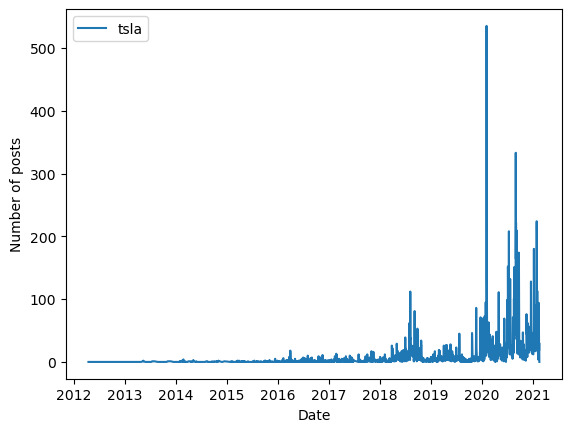

In [14]:
tsla_posts_by_date = posts_by_date.tsla.sum().to_frame()
tsla_posts_by_date.plot(xlabel="Date", ylabel="Number of posts")

<Axes: xlabel='Date', ylabel='Number of posts'>

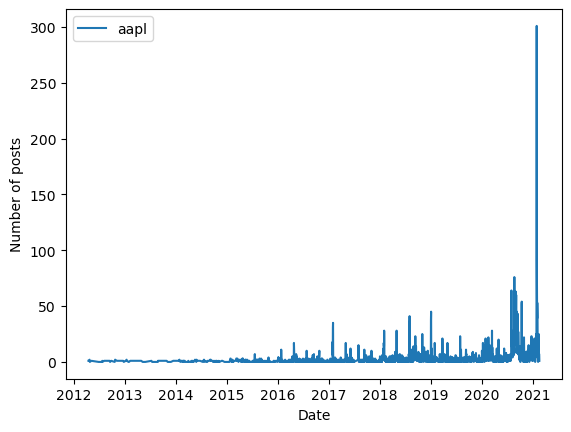

In [15]:
aapl_posts_by_date = posts_by_date.aapl.sum().to_frame()
aapl_posts_by_date.plot(xlabel="Date", ylabel="Number of posts")

<Axes: xlabel='Date', ylabel='Number of posts'>

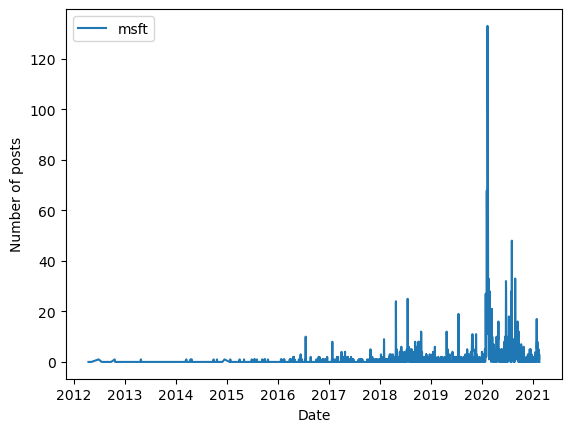

In [16]:
msft_posts_by_date = posts_by_date.msft.sum().to_frame()
msft_posts_by_date.plot(xlabel="Date", ylabel="Number of posts")

<Axes: xlabel='Date', ylabel='Number of posts'>

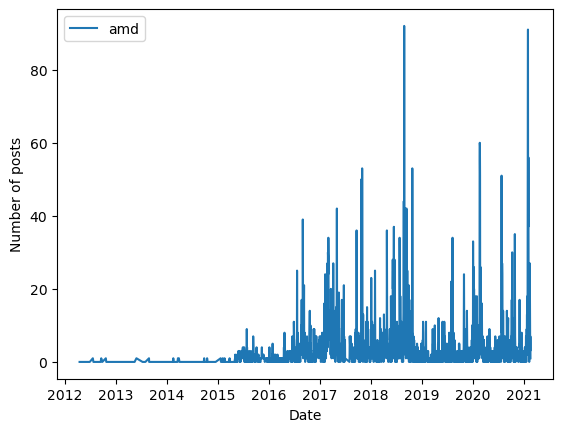

In [17]:
amd_posts_by_date = posts_by_date.amd.sum().to_frame()
amd_posts_by_date.plot(xlabel="Date", ylabel="Number of posts")

<Axes: xlabel='Date', ylabel='Number of posts'>

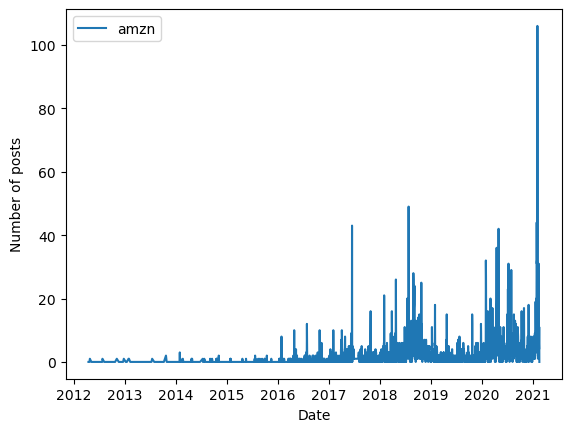

In [18]:
amzn_posts_by_date = posts_by_date.amzn.sum().to_frame()
amzn_posts_by_date.plot(xlabel="Date", ylabel="Number of posts")

In [21]:
# Finds the correlation between the popularity of a stock and its price the next week
def getPopularityPricePredictionCorrelation(stock, stock_price_csv, stock_posts_by_date):
    # Read csv with stock price data into a dataframe
    stock_prices = pd.read_csv(stock_price_csv, index_col=0, parse_dates=True)
    # Only look at close prices
    stock_close_prices = stock_prices[["Close"]]
    # Forward fill misssing dates with stock data
    padded_close_prices = stock_close_prices.asfreq("1D", method="ffill")

    # Take 7 day rolling average on prices
    avg_weekly_stock_prices = padded_close_prices.Close.rolling(7).mean()
    # Shift prices 1 week backwards
    avg_weekly_stock_prices = avg_weekly_stock_prices.shift(-7)
    # Filter our the first 7 days which now have "NaN" for price
    avg_weekly_stock_prices = avg_weekly_stock_prices[avg_weekly_stock_prices.notna()]
    # Convert from series to data frame
    avg_weekly_stock_prices = avg_weekly_stock_prices.to_frame()

    # Rename created_utc column to Date to prepare for merge
    stock_posts = stock_posts_by_date.reset_index().rename(columns={"created_utc": "Date"})
    # Convert time to the same time format used within the sock prices data frame
    stock_posts.Date = stock_posts.Date.apply(lambda time: np.datetime64(time))

    # Take 7 day rolling average for the number of posts per day for the stock in question
    stock_posts_by_date_weekly_avg = stock_posts_by_date[stock].rolling(7).mean()
    # Filter out NaN
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg[stock_posts_by_date_weekly_avg.notna()]
    # Convert to data frame
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg.to_frame()
    # Merge data frames
    populartiy_to_following_week_close_price = stock_posts_by_date_weekly_avg.merge(right=avg_weekly_stock_prices, right_index=True, left_index=True)
    return populartiy_to_following_week_close_price.corr().loc[stock, "Close"]

### Correlations between the number of posts per day mentioning a stock and the 7 day rolling price 1 week later

In [22]:
tsla_corr = getPopularityPricePredictionCorrelation("tsla", "TSLA.csv", tsla_posts_by_date)
aapl_corr = getPopularityPricePredictionCorrelation("aapl", "AAPL.csv", aapl_posts_by_date)
amzn_corr = getPopularityPricePredictionCorrelation("amzn", "AMZN.csv", amzn_posts_by_date)
msft_corr = getPopularityPricePredictionCorrelation("msft", "MSFT.csv", msft_posts_by_date)
amd_corr = getPopularityPricePredictionCorrelation("amd", "AMD.csv", amd_posts_by_date)
print(f"tsla_corr = {tsla_corr}\naapl_corr = {aapl_corr}\namzn_corr = {amzn_corr}\nmsft_corr = {msft_corr}\namd_corr = {amd_corr}\n")
print(f"average correlation = {(tsla_corr + aapl_corr + amzn_corr + msft_corr + amd_corr) / 5}")

tsla_corr = 0.6418828391779329
aapl_corr = 0.533514827241095
amzn_corr = 0.5384831971556492
msft_corr = 0.3293713830170534
amd_corr = 0.21474982833699888

average correlation = 0.4516004149857459


### Correlations between the sum of popularity scores of posts per day mentioning a stock and the 7 day rolling price 1 week later

In [23]:
# We began with this approach but found the correlation using the popularity score from the formula, which was (upvotes + 10 * num_comments)
# we made up was weaker than just looking at the number of posts per day. Because of this we decided to
# not use these results in our findings but have included these here to show the correlation as we will
# mention this in our presentation
tsla_popularity_corr = getPopularityPricePredictionCorrelation("popularity_score", "TSLA.csv", posts[posts.tsla].groupby("created_utc").popularity_score.sum().to_frame())
aapl_popularity_corr = getPopularityPricePredictionCorrelation("popularity_score", "AAPL.csv", posts[posts.aapl].groupby("created_utc").popularity_score.sum().to_frame())
amzn_popularity_corr = getPopularityPricePredictionCorrelation("popularity_score", "AMZN.csv", posts[posts.amzn].groupby("created_utc").popularity_score.sum().to_frame())
msft_popularity_corr = getPopularityPricePredictionCorrelation("popularity_score", "MSFT.csv", posts[posts.msft].groupby("created_utc").popularity_score.sum().to_frame())
amd_popularity_corr = getPopularityPricePredictionCorrelation("popularity_score", "AMD.csv", posts[posts.amd].groupby("created_utc").popularity_score.sum().to_frame())
print(f"average correlation = {(tsla_popularity_corr + aapl_popularity_corr + amzn_popularity_corr + msft_popularity_corr + amd_popularity_corr) / 5}")

average correlation = 0.30326160260354024


# Finding #1: The frequency of a company mentioned has a moderate correlation 

## Chart: Normalized post freqency vs. stock price 

In [80]:
def normalizedPostFreqencyToRollingStockPriceChart(stock, stock_posts_by_date):
    stock_prices = pd.read_csv(f"{stock.upper()}.csv", index_col=0, parse_dates=True)
    # Only look at close prices
    stock_close_prices = stock_prices[["Close"]]
    # Forward fill misssing dates with stock data
    padded_close_prices = stock_close_prices.asfreq("1D", method="ffill")

    # Take 7 day rolling average on prices
    avg_weekly_stock_prices = padded_close_prices.Close.rolling(7).mean()
    # Shift prices 1 week backwards
    avg_weekly_stock_prices = avg_weekly_stock_prices.shift(-7)
    # Filter our the first 7 days which now have "NaN" for price
    avg_weekly_stock_prices = avg_weekly_stock_prices[avg_weekly_stock_prices.notna()]
    # Convert from series to data frame
    avg_weekly_stock_prices = avg_weekly_stock_prices.to_frame()
    # Normailze for graph
    avg_weekly_stock_prices.Close = (avg_weekly_stock_prices.Close - avg_weekly_stock_prices.Close.mean()) / avg_weekly_stock_prices.Close.std()

    # Rename created_utc column to Date to prepare for merge
    stock_posts = stock_posts_by_date.reset_index().rename(columns={"created_utc": "Date"})
    # Convert time to the same time format used within the sock prices data frame
    stock_posts.Date = stock_posts.Date.apply(lambda time: np.datetime64(time))

    # Take 7 day rolling average for the number of posts per day for the stock in question
    stock_posts_by_date_weekly_avg = stock_posts_by_date[stock].rolling(7).mean()
    # Filter out NaN
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg[stock_posts_by_date_weekly_avg.notna()]
    # Convert to data frame
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg.to_frame()
    # Normalize for graph
    stock_posts_by_date_weekly_avg[stock] = (stock_posts_by_date_weekly_avg[stock] - stock_posts_by_date_weekly_avg[stock].mean()) / stock_posts_by_date_weekly_avg[stock].std()
    # Merge data frames
    populartiy_to_following_week_close_price = stock_posts_by_date_weekly_avg.merge(right=avg_weekly_stock_prices, right_index=True, left_index=True)
    populartiy_to_following_week_close_price.plot(title=f"Normalized post frequency per week mentioning {stock.upper()} vs. Normalized {stock.upper()} stock price the following week")

In [71]:
def regressionPlotForPostFrequency(stock, stock_posts_by_date):
    # Read csv with stock price data into a dataframe
    stock_prices = pd.read_csv(f"{stock.upper()}.csv", index_col=0, parse_dates=True)
    # Only look at close prices
    stock_close_prices = stock_prices[["Close"]]
    # Forward fill misssing dates with stock data
    padded_close_prices = stock_close_prices.asfreq("1D", method="ffill")

    # Take 7 day rolling average on prices
    avg_weekly_stock_prices = padded_close_prices.Close.rolling(7).mean()
    # Shift prices 1 week backwards
    avg_weekly_stock_prices = avg_weekly_stock_prices.shift(-7)
    # Filter our the first 7 days which now have "NaN" for price
    avg_weekly_stock_prices = avg_weekly_stock_prices[avg_weekly_stock_prices.notna()]
    # Convert from series to data frame
    avg_weekly_stock_prices = avg_weekly_stock_prices.to_frame()

    # Rename created_utc column to Date to prepare for merge
    stock_posts = stock_posts_by_date.reset_index().rename(columns={"created_utc": "Date"})
    # Convert time to the same time format used within the sock prices data frame
    stock_posts.Date = stock_posts.Date.apply(lambda time: np.datetime64(time))

    # Take 7 day rolling average for the number of posts per day for the stock in question
    stock_posts_by_date_weekly_avg = stock_posts_by_date[stock].rolling(7).mean()
    # Filter out NaN
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg[stock_posts_by_date_weekly_avg.notna()]
    # Convert to data frame
    stock_posts_by_date_weekly_avg = stock_posts_by_date_weekly_avg.to_frame()
    # Merge data frames
    populartiy_to_following_week_close_price = stock_posts_by_date_weekly_avg.merge(right=avg_weekly_stock_prices, right_index=True, left_index=True)
    
    populartiy_to_following_week_close_price.columns = [f"Number of posts mentioning {stock.upper()}", "Close Price"]
    
    sns.regplot(data=populartiy_to_following_week_close_price, x=f"Number of posts mentioning {stock.upper()}", y="Close Price")

<Axes: xlabel='Number of posts mentioning TSLA', ylabel='Close Price'>

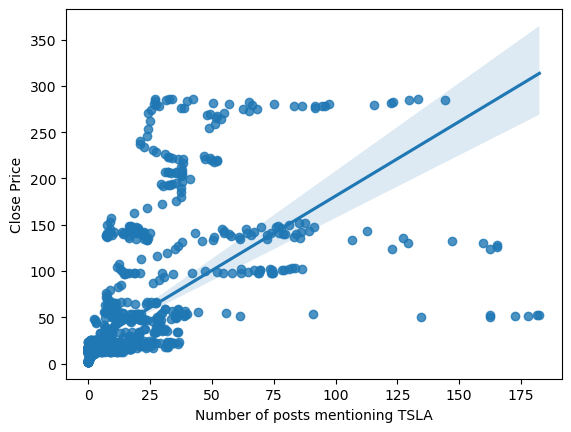

In [73]:
regressionPlotForPostFrequency("tsla", tsla_posts_by_date)

<Axes: xlabel='Number of posts mentioning MSFT', ylabel='Close Price'>

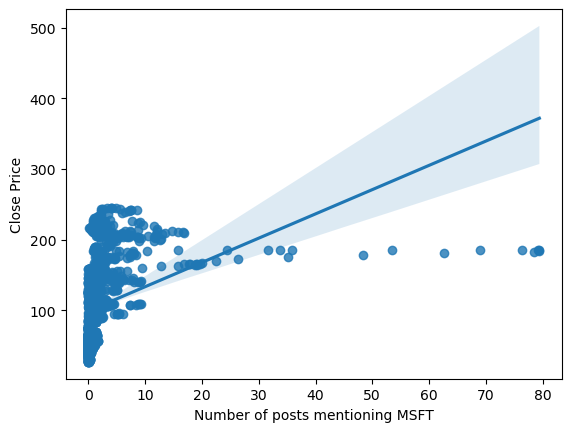

In [74]:
regressionPlotForPostFrequency("msft", msft_posts_by_date)

<Axes: xlabel='Number of posts mentioning AAPL', ylabel='Close Price'>

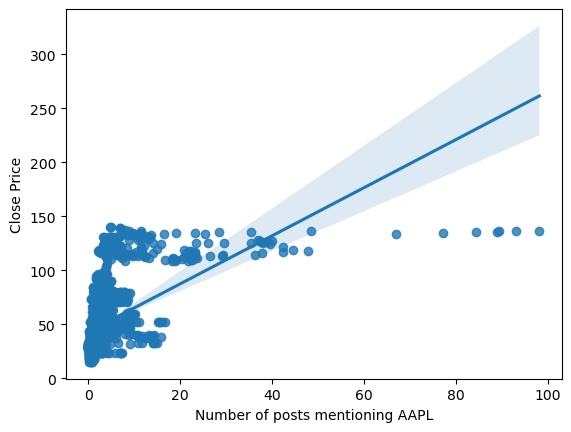

In [75]:
regressionPlotForPostFrequency("aapl", aapl_posts_by_date)

<Axes: xlabel='Number of posts mentioning AMD', ylabel='Close Price'>

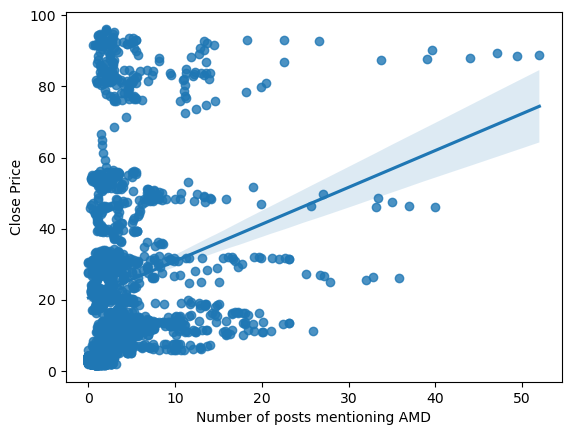

In [76]:
regressionPlotForPostFrequency("amd", amd_posts_by_date)

<Axes: xlabel='Number of posts mentioning AMZN', ylabel='Close Price'>

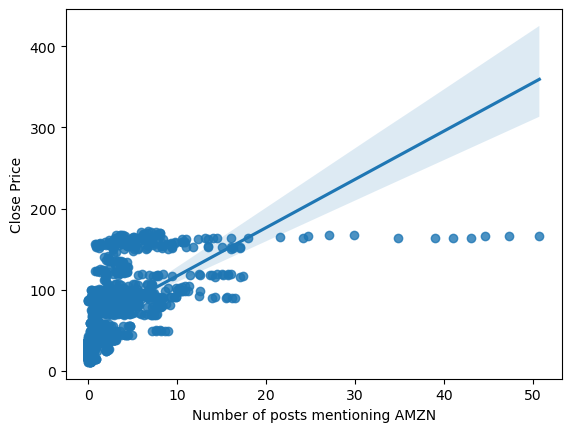

In [77]:
regressionPlotForPostFrequency("amzn", amzn_posts_by_date)

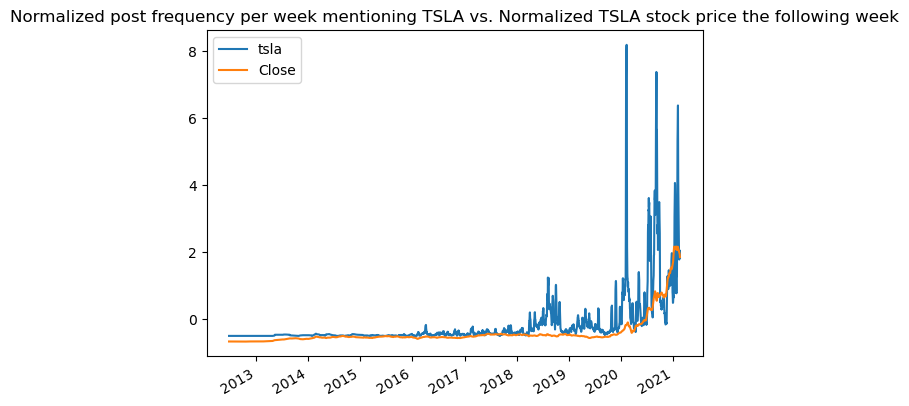

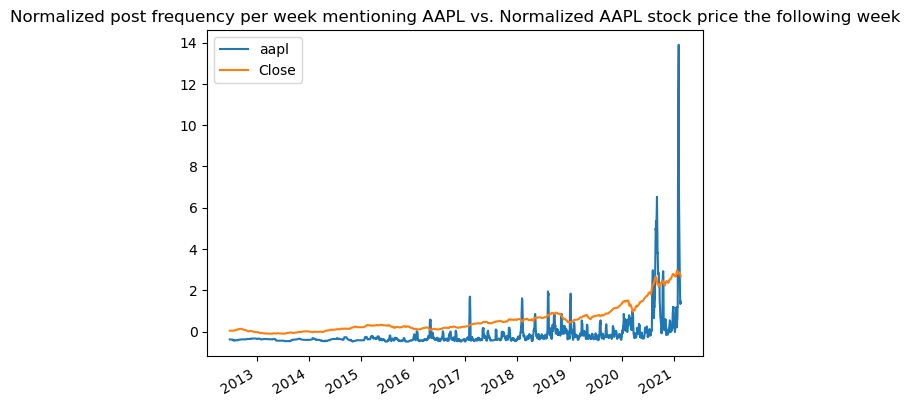

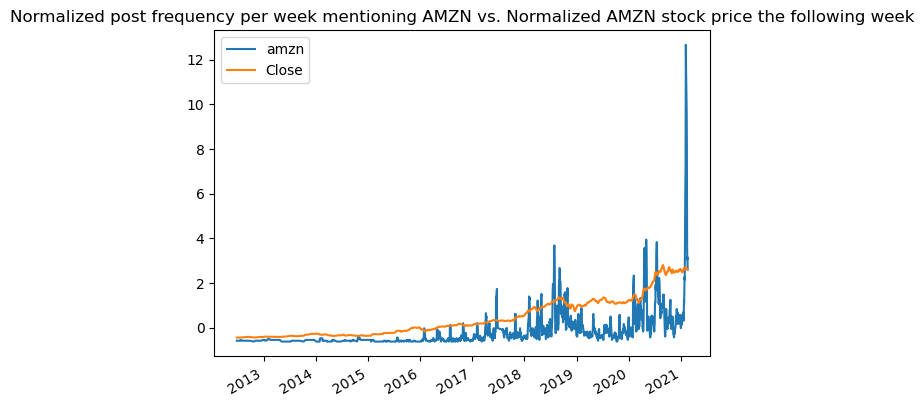

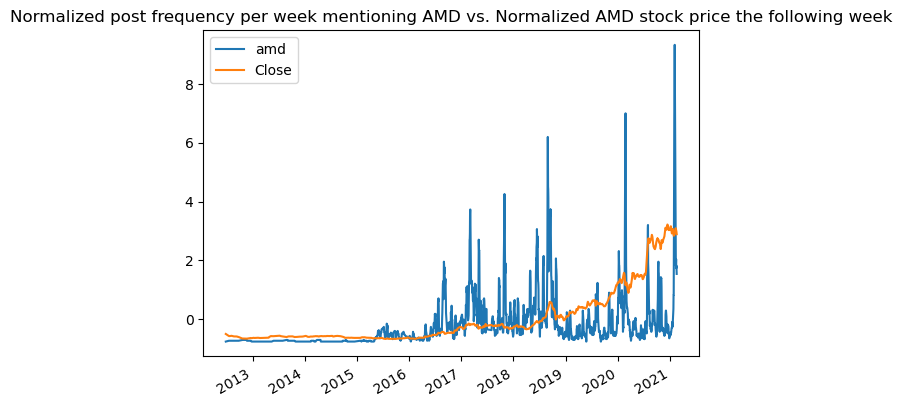

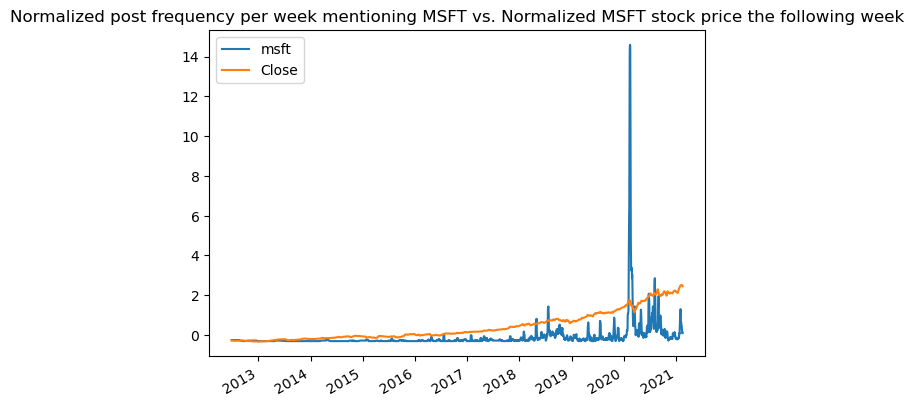

In [82]:
normalizedPostFreqencyToRollingStockPriceChart("tsla", tsla_posts_by_date)
normalizedPostFreqencyToRollingStockPriceChart("aapl", aapl_posts_by_date)
normalizedPostFreqencyToRollingStockPriceChart("amzn", amzn_posts_by_date)
normalizedPostFreqencyToRollingStockPriceChart("amd", amd_posts_by_date)
normalizedPostFreqencyToRollingStockPriceChart("msft", msft_posts_by_date)

### Managerial insight: We can watch for a stock's popularity rising on r/wallstreetbets using something like a webscraper, and use that information to make decisions on stocks that are likely to increase in price in the next week.

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [30]:
# Example of how the vader model works
vader.polarity_scores("I hate apple")

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [31]:
posts["sentiment"] = posts.title.apply(lambda title: vader.polarity_scores(title)["compound"])

In [35]:
def findCorrFromSentimentToStockPricePrediction(ticker, stockCsvName, positiveOrNegative):
    # Read in the stock data csv for the provided stock ticker
    stock = pd.read_csv(stockCsvName, index_col=0, parse_dates=True)
    # Forward fill data for missing dates with no stock price data
    stockPadded = stock.asfreq('1D', method='ffill')
    # Compute the 7 day rolling close price average for each date
    stockCloseRollingAvg = stockPadded.Close.rolling(7).mean()
    # Shift the prices 1 week backwards within the dataframe
    stockCloseWeeklyAvg = stockCloseRollingAvg.shift(-7).to_frame()
    
    # Isolate all posts that mention a the stock
    tickerPosts = posts[posts[ticker]].copy()
    # Rename "created_utc" column to "Date"
    tickerPosts.rename(columns={"created_utc": "Date"}, inplace=True)
    # Set "Date" column to be the index of the dataframe
    tickerPosts = tickerPosts.set_index("Date")
    
    netSentimentByWeek = None
    if positiveOrNegative == "positive":
        # Here if postiveOrNegative is "positive" we set the net sentient score to be the sum of all positive sentiement scores per date
        netSentimentByWeek = tickerPosts[tickerPosts.sentiment > 0].groupby("Date").sentiment.sum().rolling(7).mean().to_frame()
    else:
        # Here if postiveOrNegative is "negative" we set the net sentient score to be the sum of all negative sentiement scores per date
        netSentimentByWeek = tickerPosts[tickerPosts.sentiment < 0].groupby("Date").sentiment.sum().rolling(7).mean().to_frame()
        
    # Merge the data
    sentiment_price_merge = netSentimentByWeek.merge(right = stockCloseWeeklyAvg, right_index = True, left_index = True)
    
    # Return the correlation between the summed sentiment and the close price the next week
    return sentiment_price_merge.corr().loc["sentiment","Close"]

In [36]:
# Computing the average correlation between total positve sentiment and the price of the stock the next week
tslaPosCorr = findCorrFromSentimentToStockPricePrediction("tsla", "TSLA.csv", "positive")
aaplPosCorr = findCorrFromSentimentToStockPricePrediction("aapl", "AAPL.csv", "positive")
amdPosCorr = findCorrFromSentimentToStockPricePrediction("amd", "AMD.csv", "positive")
amznPosCorr = findCorrFromSentimentToStockPricePrediction("amzn", "AMZN.csv", "positive")
msftPosCorr = findCorrFromSentimentToStockPricePrediction("msft", "MSFT.csv", "positive")
avgPosCorr = (aaplPosCorr + tslaPosCorr + amdPosCorr + amznPosCorr + msftPosCorr) / 5
avgPosCorr

0.4037524248510106

In [83]:
# Computing the average correlation between total negative sentiment and the price of the stock the next week
tslaNegCorr = findCorrFromSentimentToStockPricePrediction("tsla", "TSLA.csv", "negative")
aaplNegCorr = findCorrFromSentimentToStockPricePrediction("aapl", "AAPL.csv", "negative")
amdNegCorr = findCorrFromSentimentToStockPricePrediction("amd", "AMD.csv", "negative")
amznNegCorr = findCorrFromSentimentToStockPricePrediction("amzn", "AMZN.csv", "negative")
msftNegCorr = findCorrFromSentimentToStockPricePrediction("msft", "MSFT.csv", "negative")
avgNegCorr = (aaplNegCorr + tslaNegCorr + amdNegCorr + amznNegCorr + msftNegCorr) / 5
avgNegCorr

-0.29657795125358766

# Finding 2: There is a moderate correlation between an increase of positive sentiment in a stock and it's price the next week

## Charts:

In [86]:
def normalizedPostSentimentToRollingStockPriceChart(stock, tickerPosts, positiveOrNegative):
    stock_prices = pd.read_csv(f"{stock.upper()}.csv", index_col=0, parse_dates=True)
    # Only look at close prices
    stock_close_prices = stock_prices[["Close"]]
    # Forward fill misssing dates with stock data
    padded_close_prices = stock_close_prices.asfreq("1D", method="ffill")

    # Take 7 day rolling average on prices
    avg_weekly_stock_prices = padded_close_prices.Close.rolling(7).mean()
    # Shift prices 1 week forward
    avg_weekly_stock_prices = avg_weekly_stock_prices.shift(7)
    # Filter our the first 7 days which now have "NaN" for price
    avg_weekly_stock_prices = avg_weekly_stock_prices[avg_weekly_stock_prices.notna()]
    # Convert from series to data frame
    avg_weekly_stock_prices = avg_weekly_stock_prices.to_frame()
    # Normailze for graph
    avg_weekly_stock_prices.Close = (avg_weekly_stock_prices.Close - avg_weekly_stock_prices.Close.mean()) / avg_weekly_stock_prices.Close.std()

    # Sum sentiment by date and take 7 day rolling averages
    tickerPosts = tickerPosts.rename(columns={"created_utc": "Date"})
    netSentimentByWeek = None
    
    if positiveOrNegative == "positive":
        # Here if postiveOrNegative is "positive" we set the net sentient score to be the sum of all positive sentiement scores per date
        netSentimentByWeek = tickerPosts[tickerPosts.sentiment > 0].groupby("Date").sentiment.sum().rolling(7).mean().to_frame()
    else:
        # Here if postiveOrNegative is "negative" we set the net sentient score to be the sum of all negative sentiement scores per date
        netSentimentByWeek = tickerPosts[tickerPosts.sentiment < 0].groupby("Date").sentiment.sum().rolling(7).mean().to_frame()
    
    netSentimentByWeek.sentiment = (netSentimentByWeek.sentiment - netSentimentByWeek.sentiment.mean()) / netSentimentByWeek.sentiment.std()
    sentiment_price_merge = netSentimentByWeek.merge(right = avg_weekly_stock_prices, right_index = True, left_index = True)

    sentiment_price_merge.plot(title=f"Normalized total {positiveOrNegative} sentiment for {stock.upper()} vs. Normalized {stock.upper()} close price the following week")

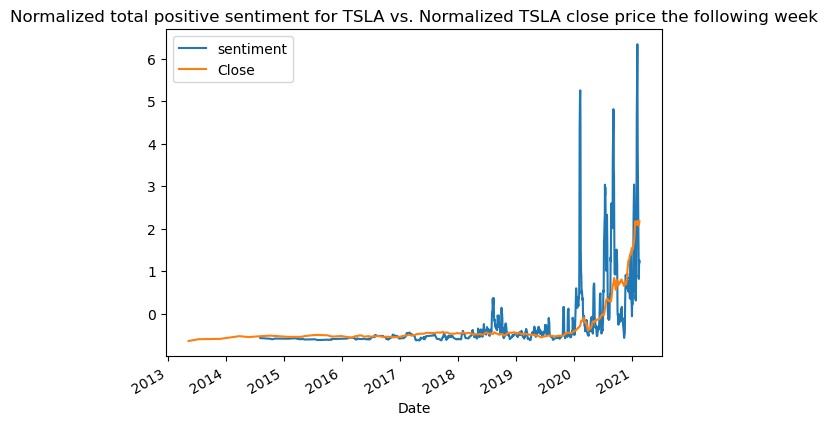

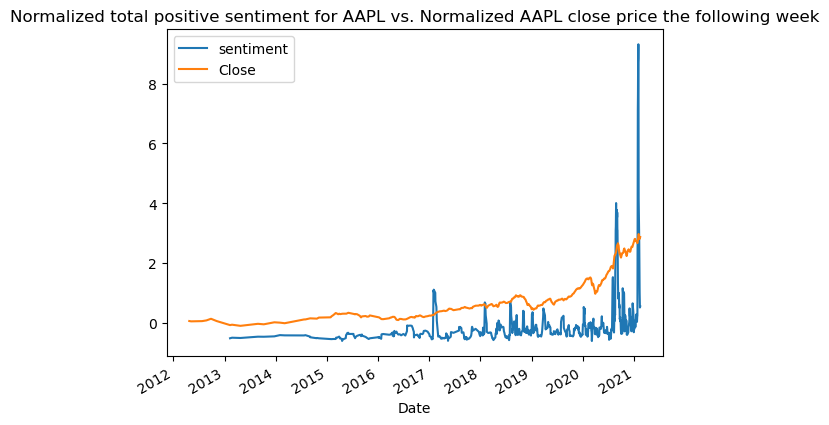

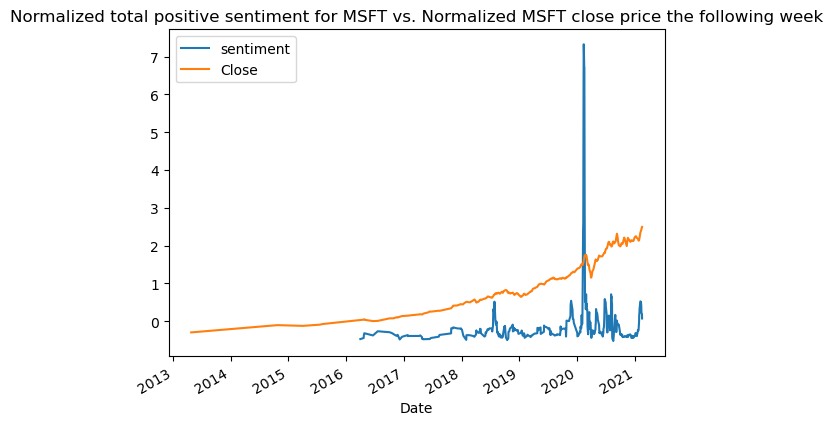

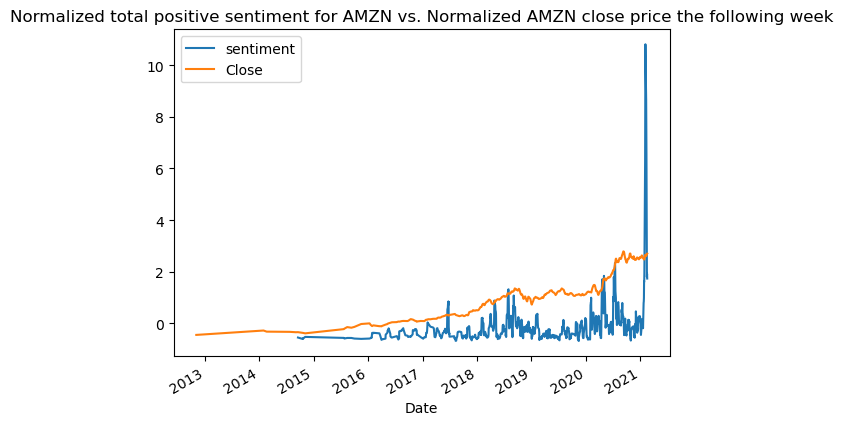

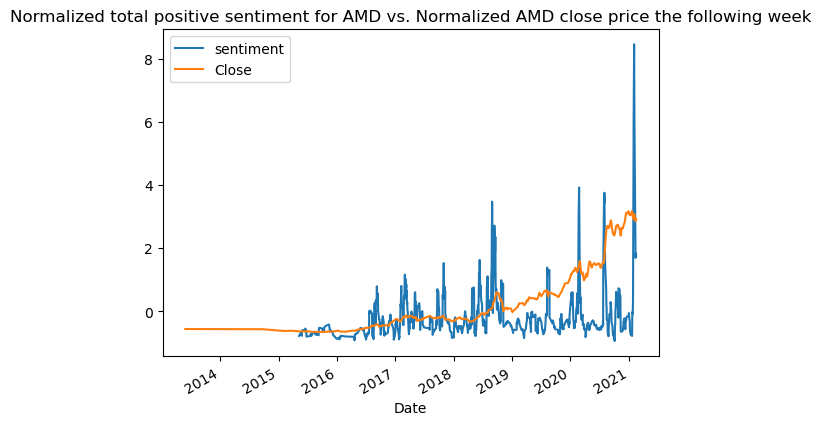

In [87]:
normalizedPostSentimentToRollingStockPriceChart("tsla", posts[posts.tsla], "positive")
normalizedPostSentimentToRollingStockPriceChart("aapl", posts[posts.aapl], "positive")
normalizedPostSentimentToRollingStockPriceChart("msft", posts[posts.msft], "positive")
normalizedPostSentimentToRollingStockPriceChart("amzn", posts[posts.amzn], "positive")
normalizedPostSentimentToRollingStockPriceChart("amd", posts[posts.amd], "positive")

### Managerial insight: When looking at stocks to buy based on information from r/wallstreet bets, it could be a positive indicator that the stock will do will in the coming weeks if the sentiment is positive

# Finding 3: There is a **NO** correlation between an increase of positive negative in a stock and it's price the next week

## Charts

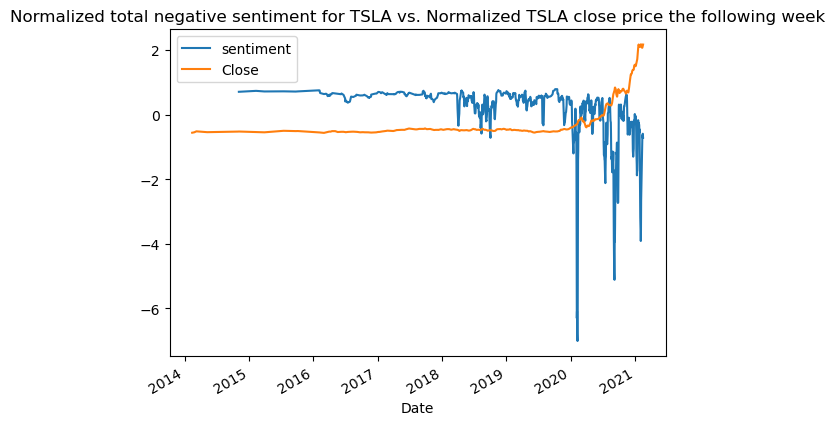

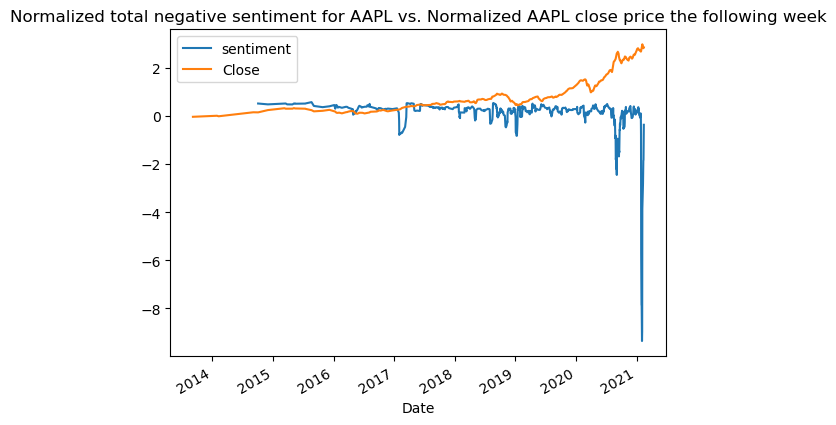

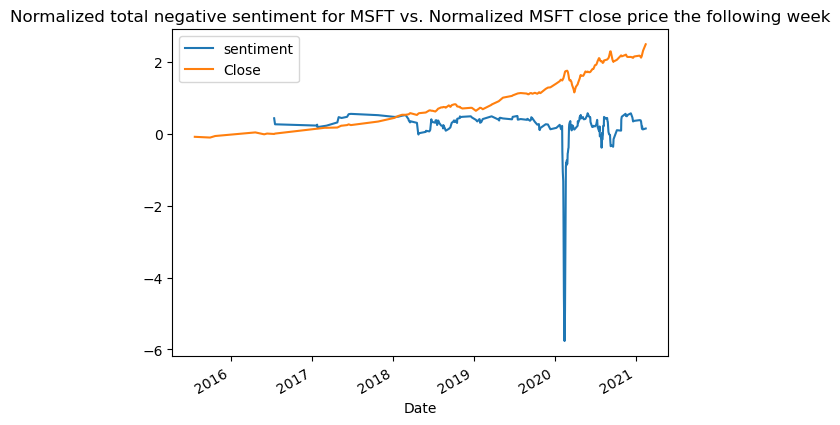

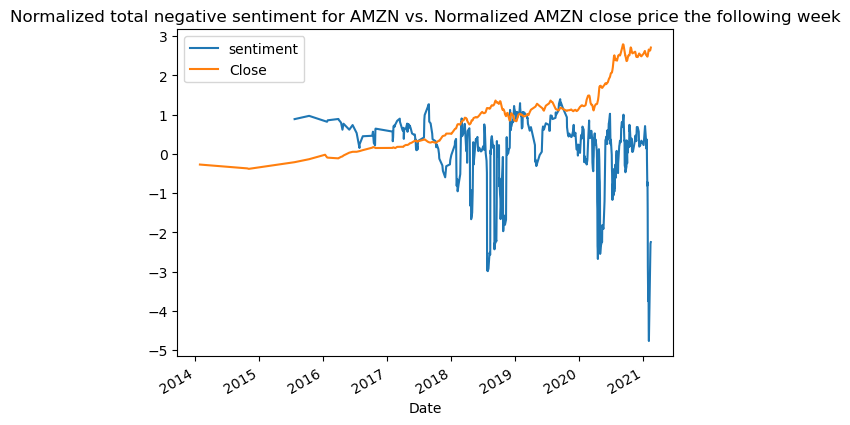

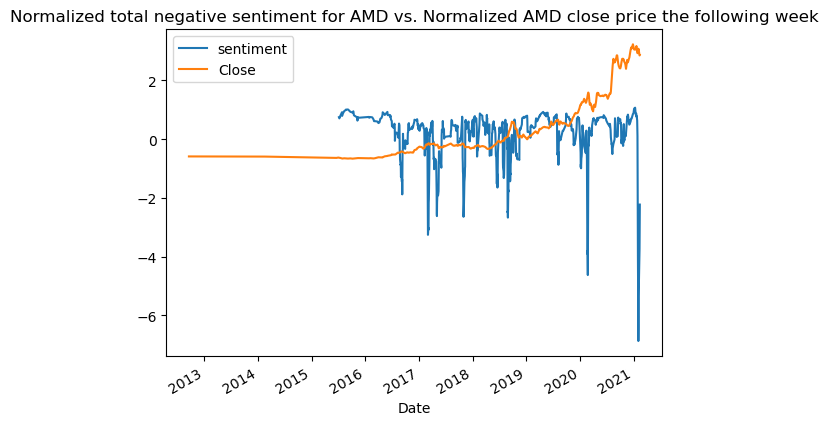

In [88]:
normalizedPostSentimentToRollingStockPriceChart("tsla", posts[posts.tsla], "negative")
normalizedPostSentimentToRollingStockPriceChart("aapl", posts[posts.aapl], "negative")
normalizedPostSentimentToRollingStockPriceChart("msft", posts[posts.msft], "negative")
normalizedPostSentimentToRollingStockPriceChart("amzn", posts[posts.amzn], "negative")
normalizedPostSentimentToRollingStockPriceChart("amd", posts[posts.amd], "negative")

### Managerial insight: When looking at stocks to buy based on information from r/wallstreet bets, it doesn't matter if the sentiment seems to be negative, it seems the strongest correlation is simply post freqency on a stock so focus on that.